# 一、学习过程小代码汇总
## 1.1 演示模块的直接替换
### 1.1.1 直接随便写个类修改Conv2d

In [3]:
# 注意，执行此cell，需要restart。
# 此cell用于演示替换nn.Conv2d
import torch
import torch.nn as nn
class QuantConv2d():
    def __init__(self):
        print(f"__init__")
    
    def __call__(self, input1):
        print(input1)
        
print(nn.Conv2d)
nn.Conv2d = QuantConv2d()
print(nn.Conv2d)

__init__


## 1.2 工厂模式

🧙🏾‍♂️: 使用静态方法来初始化对象是一种编程模式，通常被称为工厂方法模式。这种模式的目的是提供一个接口来创建对象，而不是直接使用构造函数。这样做的好处有很多：

1. **更清晰的语义**：静态方法可以有描述性的名称，这使得代码更易读、更易理解。例如，`QuantizationMethod.per_tensor(...)`明确表示我们正在创建一个针对整个张量的量化方法。

2. **灵活性**：静态方法可以根据输入参数返回不同的对象实例或子类实例。这为创建对象提供了更大的灵活性。

3. **参数简化**：静态方法可以为某些参数提供默认值或执行特定的预处理，从而简化对象的创建。

在给定的代码中，`QuantizationMethod`类有两个静态方法：`per_tensor`和`per_channel`。这两个方法为用户提供了一种简洁、描述性的方式来创建`QuantizationMethod`对象，而不需要直接调用构造函数并传递大量参数。

例如，`QuantizationMethod.per_tensor(8, Algorithm("max"))`为我们创建了一个使用8位和最大值算法的整个张量的量化方法。这比直接使用构造函数更直观、更简洁。

总的来说，通过静态方法初始化是一种使代码更加清晰、灵活和简洁的方法。你还有其他问题或疑虑吗？🔍

In [ ]:
self.input_quantizer_  = Quantizer(QuantizationMethod.per_tensor(8, Algorithm("max")))

## 1.3 collect_data--解释per_channel

In [31]:
import torch
dim = 0 # -1为per—tensor    0为per_weight  之所以是0是因为weight的形状


a = torch.arange(27).reshape(3, 1, 3, 3) # 输出通道,输入通道,kernel_size1,kernel_size2
print(f"==[原始的a]==\n", a)

reduce_shape = list(range(len(a.shape)-1, -1, -1)) 
print(f"==[del前的reduce_shape]==".ljust(40), reduce_shape)

del reduce_shape[reduce_shape.index(dim)]
print(f"==[del后的reduce_shape]==".ljust(40), reduce_shape)


for i in reduce_shape: # 
    if a.shape[i] > 1:
        a = torch.max(a, dim=i, keepdim=True)[0]
        print(f"==[当前i={i}]==\n", f"对应\na={a}")
        
print(a)

==[原始的a]==
 tensor([[[[ 0,  1,  2],
          [ 3,  4,  5],
          [ 6,  7,  8]]],


        [[[ 9, 10, 11],
          [12, 13, 14],
          [15, 16, 17]]],


        [[[18, 19, 20],
          [21, 22, 23],
          [24, 25, 26]]]])
==[del前的reduce_shape]==                  [3, 2, 1, 0]
==[del后的reduce_shape]==                  [3, 2, 1]
==[当前i=3]==
 对应
a=tensor([[[[ 2],
          [ 5],
          [ 8]]],


        [[[11],
          [14],
          [17]]],


        [[[20],
          [23],
          [26]]]])
==[当前i=2]==
 对应
a=tensor([[[[ 8]]],


        [[[17]]],


        [[[26]]]])
tensor([[[[ 8]]],


        [[[17]]],


        [[[26]]]])


In [30]:
b = torch.zeros((1, 2))

b
torch.max(b, dim=0, keepdim=True)

torch.return_types.max(
values=tensor([[0., 0.]]),
indices=tensor([[0, 0]]))

## 1.4 直方图 torch api

tensor([1., 2., 3., 2., 1.])


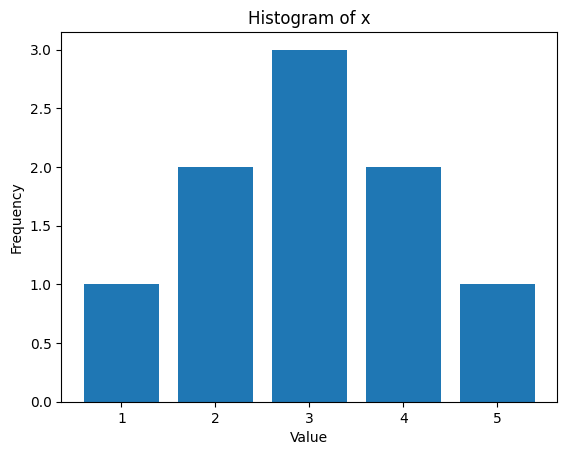

In [3]:
import torch
import matplotlib.pyplot as plt

# 创建一个简单的张量
x = torch.tensor([1, 2, 2, 3, 3, 3, 4, 4, 5], dtype=torch.float32)

# 使用torch.histc计算直方图
hist = torch.histc(x, bins=5, min=1, max=5)

print(hist) # 输出: tensor([1., 2., 3., 2., 1.])

# 使用matplotlib绘制直方图
plt.bar(range(1, 6), hist.numpy())
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of x')
plt.show()


## 1.5 宽度不变。hist改变解释

amax=4.1014933586120605
tensor([152., 137.,  86.,  61.,  30.,  17.,   4.,   2.,   3.,   2.])


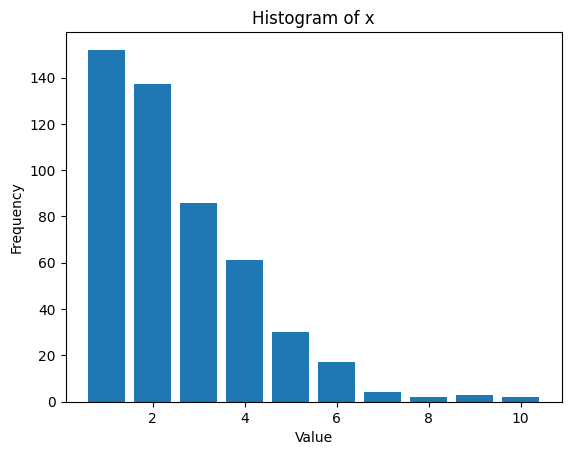

In [6]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(0)

x = torch.randn(1000)
x_max = x.abs().max().item()
print(f"amax={x_max}")


_num_bins = 10
_calib_bin_edges = torch.linspace(0, x_max, _num_bins + 1)

hist = torch.histc(x, bins=_num_bins, min=0, max=_calib_bin_edges[-1])
print(hist)
plt.bar(range(1, 11), hist.numpy())
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of x')
plt.show()

tensor(0.4101)
4.1014933586120605
13


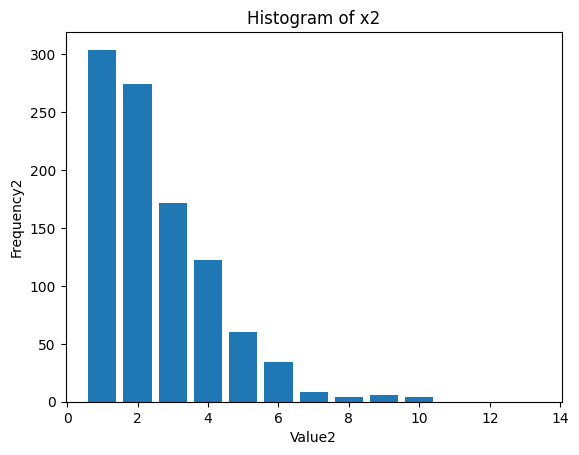

In [2]:
_calib_hist = hist # 让_calib_hist记录上一次的hist


# 下面模拟x_max增加后的效果
width = _calib_bin_edges[1] - _calib_bin_edges[0]
print(width)
print(x_max)
x_max = x_max + 1
_num_bins = int((x_max / width).ceil().item()) 
print(_num_bins)   
_calib_bin_edges = torch.arange(0, x_max + width, width)
hist2 = torch.histc(x, bins=_num_bins, min=0, max=_calib_bin_edges[-1])
hist2[:_calib_hist.numel()] += _calib_hist


plt.bar(range(1, _num_bins+1), hist2.numpy())
plt.xlabel('Value2')
plt.ylabel('Frequency2')
plt.title('Histogram of x2')
plt.show()